In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# load the data and make them compatible
train = pd.read_csv("train.csv").to_numpy()
test = pd.read_csv("test.csv").to_numpy()
X = np.delete(train, (0), axis = 1)
y = train[:,0]

In this dataset, each digit is presented by a length 784 vector. Its original form is a 28*28 square matrix, where each entry represents the color of a pixel in the corresponding 28*28 square image. To better understand the digits themselves, we can convert the vector back to the image.

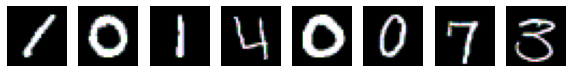

In [4]:
def display(data):
    fig = plt.figure(figsize=(10, 10))
    columns = 8
    rows = 1
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.imshow(np.reshape(data[i], (28, 28)),cmap='cubehelix') # convert the vector back to matrix
    plt.show()
 
display(X)

Here are the first 36 digits. As can be seen, some digits are ambiguous even to human eyes. How will the machine learning models perform? 

KNN is intuitive and seems easy to implement. I'll try it myself first.

steps:

1. for each test data, calculate its distance from all train data

2. sort the distances

3. find the nearest k train data 

4. predict test data based on the most common label among the k train data

(I'm aware that the algorithm written by myself will be inefficient when dealing with a large number of data due to reasons like inferior data structure or sorting algorithm, so for the purpose of code-testing, I'll only use a portion of the whole dataset to get the result faster)

In [9]:
import random
random.seed(42)
idx = random.sample(range(len(train)),3000) 
small_X = X[idx] # randomly choose 5000 train data
small_y = y[idx]

In [5]:
from statistics import mode

# get the Euclidean distance between two data
def get_distance(a, b): # inputs are vectors, i.e. 1-d array in numpy
    gap = a-b
    distance = sum([x**2 for x in gap])**0.5
    return distance

def get_sorted_distance(X_train, X_test, y_train):
    d_matrix = [] 
    for i in range(len(X_test)):
        d_row = [] # each entry is a distance
        for j in range(len(X_train)):
            d = get_distance(X_train[j], X_test[i])
            d_row.append(d)
        d_matrix.append(d_row) # each row contains distances from all train data for a test data
    return d_matrix

def predict_with_k(d_matrix, k):
    preds = [] # each entry is a prediction for a test data
    for i in range(len(d_matrix)):
        idx = np.argsort(d_matrix[i])[:k] # get the index for the nearest k train data
        neighbor = [y_train[each_idx] for each_idx in idx] # get the label of the nearest k train data
        try:
            pred = mode(neighbor) # this block is for the case where there is a tie
        except:
            pred = neighbor[0] # if there is a tie, it doesn't matter which one to pick
        preds.append (pred)
    return preds

In [10]:


X_train, X_test, y_train, y_test = train_test_split(small_X, small_y, test_size=0.2, random_state=42)
d_matrix = get_sorted_distance(X_train, X_test, y_train)
accuracy = []
k_values = [1, 3, 5, 10]
for k in k_values:
    preds = predict_with_k(d_matrix, k)
    each_accuracy = np.mean(preds == y_test)
    accuracy.append(each_accuracy)

([<matplotlib.axis.XTick at 0x12d3f42b0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

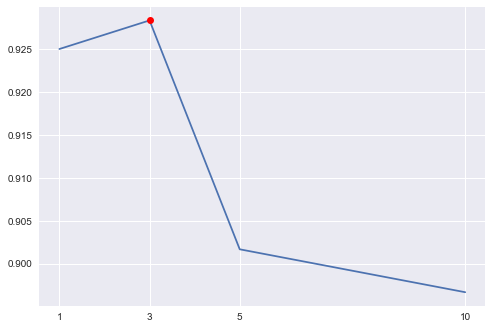

In [20]:
def learn_curve(values, accuracy):
    plt.style.use('seaborn')
    fig = plt.figure()
    ax = plt.axes()
    plt.plot(k_values, accuracy)
    idx = np.argmax(accuracy)
    plt.plot(k_values[idx], accuracy[idx], "ro")

learn_curve(k_values, accuracy)
plt.xticks(k_values)

From the learning curve we see that KNN performs the best with K = 3, which is also the common choice. But the above DIY KNN runs slow, next I'll directly use the scikit-learn package.

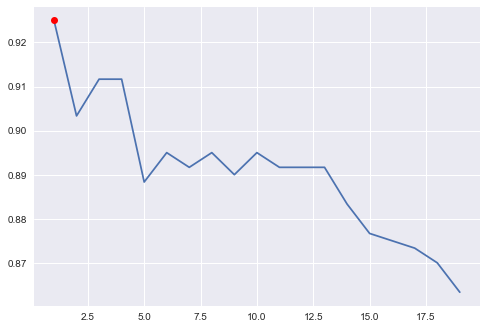

In [23]:
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1,20)

def using_KNN(k_values, X_train, y_train, X_test, y_test):
    accuracy = []
    for k in k_values:
        neigh = KNeighborsClassifier(n_neighbors = k)
        neigh.fit(X_train, y_train)
        each_accuracy = neigh.score(X_test, y_test)
        accuracy.append(each_accuracy)
    return accuracy

learn_curve(k_values, using_KNN(k_values, X_train, y_train, X_test, y_test))

By using scikit-learn package, the code runs notably faster, maybe it uses better data structure and sorting algorithm. The best value for k changes, but the ranges of accuracy is similar (90% to 92%), proves our previous DIY KNN is correct to some extend. The performance decreases drastically when k goes beyond 10, so next we'll train KNN on the full train set using k values no larger than 10, and apply cross validation with 10 folds.

In [5]:


knn_cv = KNeighborsClassifier()
k_grid = {'n_neighbors': range(1, 11)}
knn_gscv = GridSearchCV(knn_cv, k_grid, cv = 5)
knn_gscv.fit(X, y)

print(f'best k value: {knn_gscv.best_params_["n_neighbors"]}, accuracy: {knn_gscv.best_score_:.3%}')

NameError: name 'KNeighborsClassifier' is not defined

With cross validation we get a more accurate representation of KNN's performance. Result shows that the best k value is 3 with 10-fold CV accuracy 96.67%. Pretty decent for a simple algorithm like this.

Although we can't learn anything from this KNN model, if we only focus on the accuracy aspect, it did an amazing job.

We've seen how convenient it is to use scikit-learn package, why not try some other models on the whole dataset as well? 

But before advancing to other models, it might be of our interests to standardize the data for various reasons such as we want gradient descent to converge faster. 

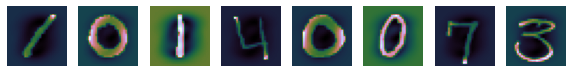

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
display(X_scaled)

After standardization, entries in each vector are no longer discrete values from 0 to 255, but continuous values ranging from 0 to 255. So the color of images change correspondingly. However, the main characteristics of the digits are still visible, so the models can run more efficiently without losing its predictive power.

Let's try using logistic regression to approach this problem. With scikit-learn package, the process is as follows:

1. import the model from sklearn
2. create an instance with proper parameters
3. fit the model with train data
4. predict new data

The default solver in this class is currently 'lbfgs', you can replace it with 'sag' or 'saga' but I find the default one the fastest. 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)


In [91]:

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9175

The warning shows that gradient descent fails to converge with the default max_iter = 100. We can change the solver to another one which converges faster (like liblinear), but the trade-off here is that it might be expensive to compute. After some trial and error, I decided to increase the number of iterations and stick with the default solver 'lbfgs'. 

In [97]:
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train, y_train)
logisticRegr.score(X_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9008333333333334

With up to 1000 iterations, gradient descent converges. But as you might have noticed, the accuracy doesn't change. This means even though the previous gradient descent didn't converge, it's still pretty close to the optimal parameters.

In [6]:
preds = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(y_test, preds)
import seaborn as sn
plt.figure(figsize = (8,8))

sn.heatmap(cm, annot=True, fmt=".0f", cmap = 'cubehelix', square = True)
plt.savefig('cm.png')

NameError: name 'logisticRegr' is not defined

Personally I'm more interested in the wrong predictions. I wonder whether the algorithm is problematic in certain cases or it's just due to awful writing. Let's take a look at some of them with a little modification on the display function previously written.

In [3]:
wrong_idx = []

for i in range(len(preds)):
    if preds[i] != y_test[i]:
        wrong_idx.append(i)

wrong_preds = X_test[wrong_idx]


fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 1
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(wrong_preds[i], (28, 28)),cmap='cubehelix') # convert the vector back to matrix
    plt.title(f'True: {y_test[wrong_idx[i]]}\nPrediction: {preds[wrong_idx[i]]}')

NameError: name 'preds' is not defined

It's understandable to misclassify some of the digits because they are written in an ambiguous way. As for others, it might due to the unconventional way of writing which mix patterns of other digits. We can re-run the whole process but with original data (i.e. without standardization) to get clearer images. It's provided in the README file.

It might also be fun to try SVM.

In [27]:


steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel='poly'))]
pipeline = Pipeline(steps)
parameters = {'SVM__C':[0.001, 0.01, 0.1, 1, 10, 100], 'SVM__gamma':[0.01, 0.1, 1, 10]}
svm_gscv = GridSearchCV(pipeline, param_grid=parameters, cv=5)
svm_gscv.fit(X_train, y_train)

In [ ]:
svm = SVC(kernel = 'poly')
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

This digit recognition project ends here, but an intereting idea comes to my mind. 

Here each data is a vector whose entry means the color of a pixel, can we think of a man's life like this? Each man's life is a data, it can be viewed as a vector composed by the thing he does in every second of his life. We can quantify the "thing" into a number using a certain standard, just as the standard for mapping colors. So we can essentially vectorize a man. To this point, we can then use machine learning algorithm to analyze this man, make prediction to his future.

Of course it's impractical from every asepct, but it's fun to think. I believe I get this idea from this conversation in the TV series West World:

Bernard Lowe : The park is an experiment. A testing chamber. The guests are the variables and the hosts are the controls. When guests come to the park, they don't know they're being watched. We get to see their true selves. Their every choice reveals another part of their cognition. Their drives. So that Delos can understand them. So that Delos can copy them.

Dr. Robert Ford : Every piece of information in the world has been copied. Backed up. Except the human mind, the last analog device in a digital world.

Bernard Lowe : __We weren't here to code the hosts. We were here to decode the guests__.

Dr. Robert Ford : Humans are playing at resurrection. They want to live forever. They don't want you to become them, they want to become... you. Your free will, that most beautiful, most elusive force in the universe, is, as I told you... a mistake.

Bernard Lowe : We never had free will. Only the illusion of it.